In [1]:
import pandas as pd, numpy as np
from rdkit import Chem
from itertools import combinations
from rdkit.DataStructs import CreateFromBitString, TanimotoSimilarity

In [2]:
X = pd.read_csv("data/trainMatrix.csv")

In [3]:
Y = pd.read_csv("data/curedData.csv", usecols=["label"]).squeeze()
_=Y.groupby(Y).indices
idxTox = _[1]
idxNoTox = _[0]

In [4]:
mutualSimilarities = pd.read_csv("results/mutualSimilarities.csv", header=None)

In [5]:
from matplotlib import pyplot as plt

In [6]:
# Function to fit exponential distribution
from scipy.stats import exponnorm as dist

## no-tox training distribution

In [ ]:
# Store only tox molecule couples and filter lower triangular matrix to flat
similaritiesNoTox = mutualSimilarities.iloc[idxNoTox, idxNoTox].values[np.triu_indices(len(idxNoTox), k = 1)]

In [102]:
np.median(similaritiesNoTox)

0.1111111111111111

In [103]:
np.percentile(similaritiesNoTox, 99)

0.6291989664082688

In [109]:
# Result of above calc
shapeNoTox=(6.413003645186349, 0.010390406427027772, 0.021012156974350046)

In [213]:
histNoTox=np.histogram(similaritiesNoTox, 45, density=True)
normalizerNoTox = float(histNoTox[0].sum())
histNoTox = ( histNoTox[0] / normalizerNoTox,
             histNoTox[1])

(0.0, 1.0)

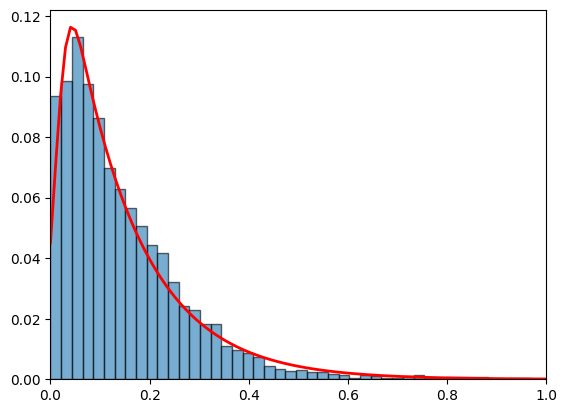

In [214]:
plt.bar( histNoTox[1][:-1], histNoTox[0],
        width=np.diff(histNoTox[1]),
       edgecolor="black", align="edge", alpha=0.6)

x = np.linspace(0,1,100)

pdf_fitted = dist.pdf(x, *shapeNoTox)
plt.plot(x, pdf_fitted/ normalizerNoTox,
       'r-', lw=2, alpha=1)
plt.xlim(0,1)

## tox training distribution

In [115]:
similaritiesTox = mutualSimilarities.iloc[idxTox, idxTox].values[np.triu_indices(len(idxTox), k = 1)]

In [116]:
np.median(similaritiesTox)

0.09302325581395349

In [117]:
np.percentile(similaritiesTox, 99)

0.5

In [118]:
shapeTox=(3.454968302037492, 0.021405449842889526, 0.02789426078451983)

In [119]:
histTox=np.histogram(similaritiesTox, 45, density=True)
normalizerTox = float(histTox[0].sum())
histTox = ( histTox[0] / normalizerTox,
             histTox[1])

(0.0, 1.0)

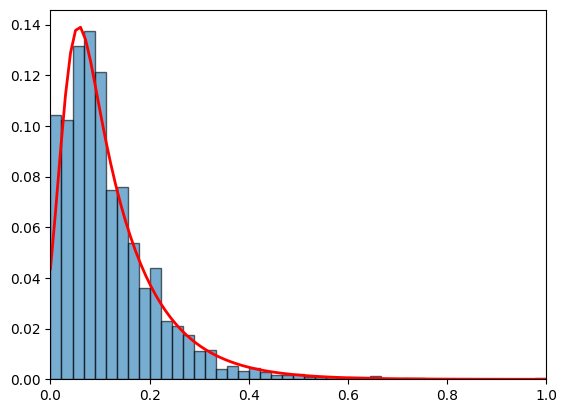

In [120]:
plt.bar( histTox[1][:-1], histTox[0],
        width=np.diff(histTox[1]),
       edgecolor="black", align="edge", alpha=0.6)

x = np.linspace(0,1,100)

pdf_fitted = dist.pdf(x, *shapeTox)
plt.plot(x, pdf_fitted/ normalizerTox,
       'r-', lw=2, alpha=1)
plt.xlim(0,1)

## CV adopting AD method

In [7]:
nCV=100
folds = 5
CVfoldsData = pd.read_csv("data/CVfoldsData.csv", index_col=0, header=[0,1])
predsConsensusCV = pd.read_csv("results/predsConsensusCV_05.csv",index_col=0)

In [8]:
from tqdm import tqdm

In [25]:
reliabilityPreds

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,True,False,True,True,True,False,True,True,False,...,True,True,True,True,False,False,True,True,True,True
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,True,True,False,False,True,False,False,...,False,False,False,True,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
729,True,True,True,True,False,False,False,False,True,False,...,True,True,True,False,False,False,True,False,True,True
730,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
731,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## Results

In [16]:
from utilsMetric import  metrics, getTableFromStats

In [10]:
reliabilityPreds=pd.read_csv("results/realiabilityPredsConsensus_05.csv", index_col=0)

In [11]:
allScores = pd.read_csv("results/CVscores.csv", header=[0,1], index_col=0)

In [12]:
consensusScores =pd.concat( 
            [allScores[cv].mean(axis=1) for cv in allScores.columns.levels[0] ], 
            axis=1, names = range(nCV))

In [13]:
metricsAD = pd.DataFrame(columns=range(nCV),
                            index=["P","N","T",*metrics] )

metricsAD.loc["P"] = [ Y[mask].value_counts()[1] for mask in reliabilityPreds.values.T]
metricsAD.loc["N"] = [ Y[mask].value_counts()[0] for mask in reliabilityPreds.values.T]
metricsAD.loc["T"] = [ sum(mask) for mask in reliabilityPreds.values.T]

for metrName, metrFun in metrics.items():
    metricsAD.loc[metrName] = [ metrFun(Y[mask], preds[mask], scores[mask])
                    for mask,preds,scores in zip(reliabilityPreds.values.astype(bool).T, predsConsensusCV.values.T, consensusScores.values.T)  ]

In [14]:
results = metricsAD.T.loc[:,["P","N","T",*metrics]].astype(float).describe()

In [19]:
getTableFromStats(results)

,median,"(1st quartile, 3rd quartile)"
P,367.0,"361.0, 373.0"
N,66.0,"63.75, 68.25"
T,432.0,"427.0, 440.0"
spec,0.48570261437908496,"0.46875, 0.5079365079365079"
sens,0.9757405348852416,"0.9705487033523087, 0.9807162534435262"
balacc,0.7318266340946924,"0.722043437559097, 0.7418591282920551"
mcc,0.5663679173551973,"0.5464322192886715, 0.5901101006944"
ppv,0.9132021884062304,"0.9093247934639329, 0.9190893728278545"
npv,0.7804878048780488,"0.7538265306122449, 0.8163875598086124"
PRcurve,0.9236456477267965,"0.916624864118417, 0.931168490766835"
